In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

In [2]:
base_input = 'tetramer_chaperone.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['default_assoc', 1.0]
['monomer_add_only', False]
['chaperone', True]
[(0, {'struct': <networkx.classes.graph.Graph object at 0x000001D3A00044E0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (1, {'struct': <networkx.classes.graph.Graph object at 0x000001D3A0004390>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (2, {'struct': <networkx.classes.graph.Graph object at 0x000001D3A0004A20>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (3, {'struct': <networkx.classes.graph.Graph object at 0x000001D3A0004908>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (4, {'struct': <networkx.classes.graph.Graph object at 0x000001D3A0004B38>, 'copies': tensor([300.], dtype=torch.float64), 'subunits': 1})]
New node added - Node index: 5 ; Node label: AM 
New node added - Node index: 6 ; Node label: AB 
New node added - Node index: 7 ; Node label: AS 
New node added - Node index: 8 ; Node label: BM 
New node added - Node index: 9 ;

In [3]:
uid_dict = {}
react_dict = {}
sys.path.append("../../")
nodes_list = []
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    nodes_list.append(gtostr(rn.network.nodes[n]['struct']))
    for r_set in rn.get_reactant_sets(n):
        r_tup = tuple(list(r_set)+[n])
#         print(r_tup)
        data = rn.network.get_edge_data(r_tup[0], n)
        reaction_id = data['uid']
        react_dict[r_tup]=reaction_id
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = ("".join(r1),"".join(r2))
#         print(reactants)
        uid_dict[(n,k)] = uid
#         react_dict[reactants] = uid

print(uid_dict)
print(react_dict)

0 -- A
1 -- M
2 -- B
3 -- S
4 -- X
5 -- AM
6 -- AB
7 -- AS
8 -- BM
9 -- MS
10 -- ABM
11 -- AMS
12 -- BS
13 -- ABS
14 -- BMS
15 -- ABMS
16 -- ABX
17 -- ABMX
{(0, 5): 0, (0, 6): 1, (0, 7): 2, (0, 10): 21, (0, 11): 22, (0, 13): 23, (0, 15): 26, (1, 5): 0, (1, 8): 3, (1, 9): 4, (1, 10): 5, (1, 11): 6, (1, 14): 24, (1, 15): 25, (2, 6): 1, (2, 8): 3, (2, 12): 7, (2, 10): 8, (2, 13): 9, (2, 14): 10, (2, 15): 11, (3, 7): 2, (3, 9): 4, (3, 12): 7, (3, 11): 12, (3, 13): 13, (3, 14): 14, (3, 15): 15, (4, 16): 16, (4, 17): 17, (5, 10): 8, (5, 11): 12, (5, 15): 18, (6, 10): 5, (6, 13): 13, (6, 16): 16, (6, 15): 19, (7, 11): 6, (7, 13): 9, (7, 15): 20, (8, 14): 14, (8, 15): 20, (8, 10): 21, (9, 14): 10, (9, 15): 19, (9, 11): 22, (10, 15): 15, (10, 17): 17, (11, 15): 11, (12, 15): 18, (12, 13): 23, (12, 14): 24, (13, 15): 25, (14, 15): 26, (16, 0): 27, (16, 2): 27, (16, 4): 27, (17, 0): 28, (17, 1): 28, (17, 2): 28, (17, 4): 28}
{(17, 0): 28, (16, 0): 27, (17, 1): 28, (17, 2): 28, (16, 2): 27, (17, 4

In [4]:
print(rn.rxn_class)
print(rn.chap_uid_map)

{(1, 1): [0, 1, 2, 3, 4, 7], (2, 1): [5, 6, 8, 9, 10, 12, 13, 14, 16, 21, 22, 23, 24], (3, 1): [11, 15, 17, 25, 26], (2, 2): [18, 19, 20]}
{4: [27, 16, 28, 17]}


In [5]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#new_kon = [0.2244, 0.2244, 0.2255, 1.6039, 1.6039, 1.6040] # M-1 s-1   
#new_kon = [0.0125, 0.1947, 0.0125, 3.6241, 3.4263, 3.4258] #Max yield Simruntime = 10sec
new_kon = new_kon + Tensor([1.]*np.array(1e0))
new_kon[16] = 1000
new_kon[26] = 3.2



update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 21}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 22}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 23}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 26}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 4}
{'k_on

In [6]:
vec_rn = VectorizedRxnNet(rn, dev='cpu',assoc_is_param=False,chap_is_param=True)
vec_rn.reset()
c_scale=1e-1
# print(vec_rn.kon)
runtime= 10
sim = VecSim(vec_rn, runtime, device='cpu')
y = sim.simulate(conc_scale=c_scale,conc_thresh=1e-1,mod_factor=10,mod_bool=True,verbose=True,yield_species=15,store_interval=-1)

Reaction rates:  tensor([   1.0000,    1.0000,    1.0000,    1.0000,    1.0000,    1.0000,
           1.0000,    1.0000,    1.0000,    1.0000,    1.0000,    1.0000,
           1.0000,    1.0000,    1.0000,    1.0000, 1000.0000,    1.0000,
           1.0000,    1.0000,    1.0000,    1.0000,    1.0000,    1.0000,
           1.0000,    1.0000,    3.2000,    1.0000,    1.0000],
       dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([ -20.,  -20.,  -20.,  -20.,  -20.,  -40.,  -40.,  -20.,  -40.,  -40.,
         -40.,  -60.,  -40.,  -40.,  -40.,  -60.,  -20.,  -20.,  -80.,  -80.,
         -80.,  -40.,  -40.,  -40.,  -40.,  -60.,  -60., -100., -100.],
       dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100., 100., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu
Using CPU
Start of simulation: memory Used:  68.4
Simulation rates:  tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.

In [7]:
for n in rn.network.nodes():
    print(gtostr(rn.network.nodes[n]['struct']) ,"--","%.4f"%(vec_rn.copies_vec[n].item()))

print(vec_rn.copies_vec)

A -- 0.0590
M -- 0.0744
B -- 0.0907
S -- 0.0001
X -- 299.9375
AM -- 0.0857
AB -- 0.0002
AS -- 0.0000
BM -- 0.5395
MS -- 0.0384
ABM -- 0.0015
AMS -- 0.6558
BS -- 0.0098
ABS -- 0.7436
BMS -- 0.1605
ABMS -- 98.3917
ABX -- 0.0100
ABMX -- 0.0525
tensor([5.8955e-02, 7.4391e-02, 9.0713e-02, 1.3238e-04, 2.9994e+02, 8.5693e-02,
        2.0667e-04, 1.7401e-05, 5.3945e-01, 3.8408e-02, 1.5209e-03, 6.5581e-01,
        9.7997e-03, 7.4362e-01, 1.6051e-01, 9.8392e+01, 9.9583e-03, 5.2516e-02],
       dtype=torch.float64, grad_fn=<MaxBackward2>)


In [8]:
print(y)

(tensor(0.9839, dtype=torch.float64, grad_fn=<DivBackward0>), tensor(1.7276e-05, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.0006, dtype=torch.float64, grad_fn=<AddBackward0>), [tensor(0.0003, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.0261, dtype=torch.float64, grad_fn=<MulBackward0>)], [tensor(0.2260, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.1070, dtype=torch.float64, grad_fn=<MulBackward0>)], 10.008234226574432, (tensor(0.3858, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(2.0011, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(4.1184, dtype=torch.float64, grad_fn=<AddBackward0>), -1))


(-15.0, 100)

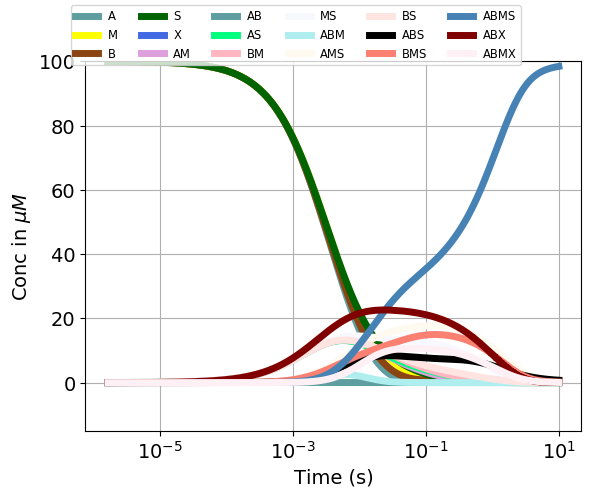

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
# nodes_list = ['A','B','M','S','AB','AM','AS','MS','BM','ABM','AMS','ABS','BMS','ABMS']
# nodes_list_repeat = ['A','B','S','AB','AS','AA','BS','ABS','AAB','AAS','AABS']
# nodes_list = ['A','S','M','ABM','ABMS','ABMX']
sim.plot_observable(nodes_list, ax=ax,legend=False,seed=198,lw=5)
# ax.set_title("runtime: " + str(runtime) + " seconds")
handles,labels = ax.get_legend_handles_labels()
ax.set_xscale("log")
fig.legend(handles,nodes_list,loc='upper center',fancybox=True,ncol=6,fontsize='small',markerscale=1.0)
ax.grid(which="major",axis="both")
ax.set_ylim(top=100)